In [8]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [9]:
def reduce_mem_usage(df):
    '''iterable through all the columns of a dataframe and modify the data type to reduce memory usage.
    '''
    start_mem = df.memory_usage().sum()
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum()
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df                


In [10]:
sample_feature = reduce_mem_usage(pd.read_csv('E:/Git-repository/data_mining/二手车价格预测组队学习/Task3 特征工程/data_for_tree.csv'))

Memory usage of dataframe is 62099672.00 MB
Memory usage after optimization is: 16520303.00 MB
Decreased by 73.4%


In [11]:
continuous_feature_names = [x for x in sample_feature.columns if x not in ['price', 'brand', 'model', 'brand']]

线性回归&五折交叉验证&模拟真实业务情况

In [12]:
sample_feature = sample_feature.dropna().replace('-', 0).reset_index(drop=True)
sample_feature['notRepairedDamage'] = sample_feature['notRepairedDamage'].astype(np.float32)
train = sample_feature[continuous_feature_names + ['price']]

train_X = train[continuous_feature_names]
train_y = train['price']

In [13]:
# 1 简单建模
from sklearn.linear_model import LinearRegression
model = LinearRegression(normalize=True)
model = model.fit(train_X, train_y)

In [7]:
# 查看线性模型的截距与权重

In [14]:
'intercept:' + str(model.intercept_)

'intercept:-110670.68277253002'

In [15]:
sorted(dict(zip(continuous_feature_names, model.coef_)).items(), key=lambda x:x[1], reverse=True)

[('v_6', 3367064.3416418773),
 ('v_8', 700675.5609398658),
 ('v_9', 170630.27723220887),
 ('v_7', 32322.66193201985),
 ('v_12', 20473.6707969639),
 ('v_3', 17868.079541497777),
 ('v_11', 11474.938996701725),
 ('v_13', 11261.764560015463),
 ('v_10', 2683.9200906023975),
 ('gearbox', 881.8225039247513),
 ('fuelType', 363.9042507215941),
 ('bodyType', 189.60271012070683),
 ('city', 44.94975120523033),
 ('power', 28.553901616752416),
 ('brand_price_median', 0.5103728134078794),
 ('brand_price_std', 0.4503634709263301),
 ('brand_amount', 0.14881120395065628),
 ('brand_price_max', 0.0031910186703119504),
 ('SaleID', 5.355989919853205e-05),
 ('train', 2.7008354663848877e-07),
 ('offerType', -2.230750396847725e-06),
 ('seller', -3.391294740140438e-06),
 ('brand_price_sum', -2.1750068681875342e-05),
 ('name', -0.0002980012713119153),
 ('used_time', -0.002515894332887234),
 ('brand_price_average', -0.4049048451011269),
 ('brand_price_min', -2.2467753486885997),
 ('power_bin', -34.42064411726994)

In [16]:
import matplotlib.pyplot as plt
subsample_index = np.random.randint(low=0, high=len(train_y), size=50)
plt.scatter(train_X['v_9'][subsample_index], train_y[subsample_index], color='black')
plt.scatter(train_X['v_9'][subsample_index], model.predict(train_X.loc[subsample_index]), color='blue')
plt.xlabel('v_9')
plt.ylabel('price')
plt.legend(['True Price', 'Predicted Price'], loc='upper right')
print('The predicted price is obvious different from true price')
plt.show()

The predicted price is obvious different from true price


<Figure size 640x480 with 1 Axes>

It is clear to see the price shows a typical exponential distribution


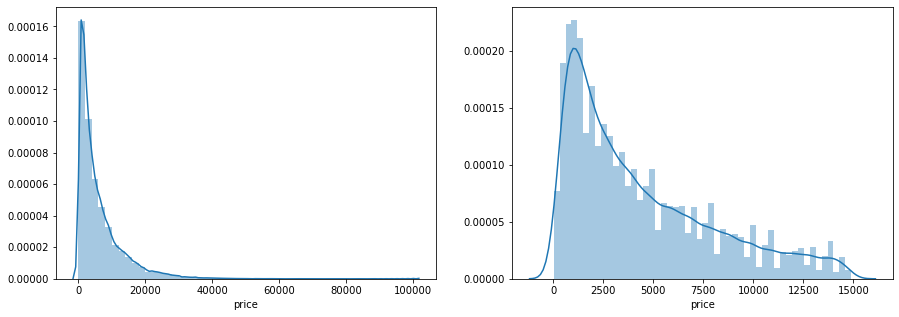

In [17]:
import seaborn as sns
print('It is clear to see the price shows a typical exponential distribution')
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(train_y)
plt.subplot(1,2,2)
sns.distplot(train_y[train_y < np.quantile(train_y, 0.9)])

In [12]:
# 数据的标签price呈现长尾分布（右偏），不利于建模

In [18]:
train_y_ln = np.log(train_y + 1)

The transformed price seems like normal distribution


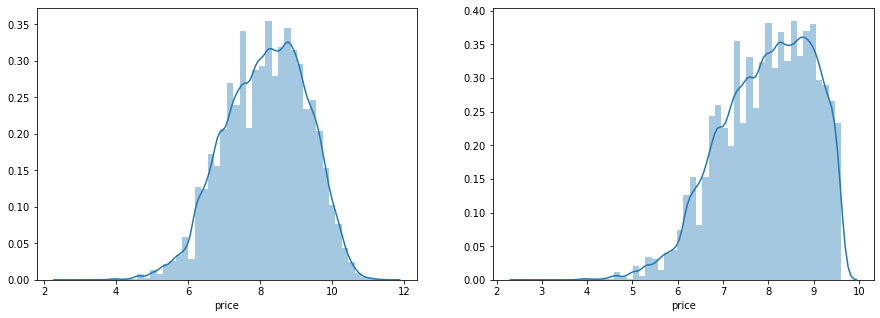

In [19]:
import seaborn as sns
print('The transformed price seems like normal distribution')
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(train_y_ln)
plt.subplot(1,2,2)
sns.distplot(train_y_ln[train_y_ln < np.quantile(train_y_ln, 0.9)])

In [20]:
model = model.fit(train_X, train_y_ln)

print('intercept:' + str(model.intercept_))
sorted(dict(zip(continuous_feature_names, model.coef_)).items(), key=lambda x:x[1], reverse=True)

intercept:18.750749465570607


[('v_9', 8.052409900567602),
 ('v_5', 5.764236596652759),
 ('v_12', 1.6182081236784163),
 ('v_1', 1.4798310582944711),
 ('v_11', 1.1669016563622117),
 ('v_13', 0.9404711296030676),
 ('v_7', 0.713727308356542),
 ('v_3', 0.6837875771076573),
 ('v_0', 0.008500518010093529),
 ('power_bin', 0.008497969302892117),
 ('gearbox', 0.007922377278335285),
 ('fuelType', 0.006684769706828693),
 ('bodyType', 0.004523520092703198),
 ('power', 0.0007161894205358566),
 ('brand_price_min', 3.334351114743061e-05),
 ('brand_amount', 2.8978797042777754e-06),
 ('brand_price_median', 1.2571172873027632e-06),
 ('brand_price_std', 6.659176363436127e-07),
 ('brand_price_max', 6.194956307517733e-07),
 ('brand_price_average', 5.999345965043507e-07),
 ('SaleID', 2.1194170039647818e-08),
 ('train', 1.8189894035458565e-12),
 ('offerType', -5.3287152468328713e-11),
 ('seller', -1.1784173636897322e-10),
 ('brand_price_sum', -1.5126504215929971e-10),
 ('name', -7.015512588871499e-08),
 ('used_time', -4.12247937235175e-0

The predicted price seems normal after np.log transforming


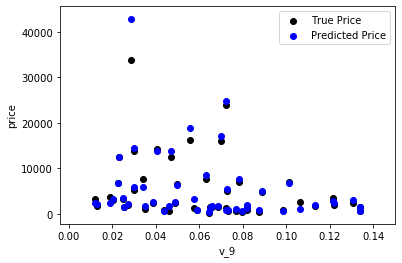

In [21]:
# 再次进行可视化
plt.scatter(train_X['v_9'][subsample_index], train_y[subsample_index], color='black')
plt.scatter(train_X['v_9'][subsample_index], np.exp(model.predict(train_X.loc[subsample_index])), color='blue')
plt.xlabel('v_9')
plt.ylabel('price')
plt.legend(['True Price', 'Predicted Price'], loc='upper right')
print('The predicted price seems normal after np.log transforming')
plt.show()

In [22]:
# 2 五折交叉验证
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, make_scorer

def log_transfer(func):
    def wrapper(y, yhat):
        result = func(np.log(y), np.nan_to_num(np.log(yhat)))
        return result
    return wrapper

In [23]:
scores = cross_val_score(model, X=train_X, y=train_y, verbose=1, cv=5, scoring=make_scorer(log_transfer(mean_absolute_error)))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.6s finished


In [24]:
# 使用线性回归模型，对未处理标签的特征数据进行五折交叉验证
print('AVG:', np.mean(scores))

AVG: 1.3658023920314537


In [25]:
# 使用线性回归模型，对处理过标签的特征数据进行五折交叉验证
scores = cross_val_score(model, X=train_X, y=train_y_ln, verbose=1, cv=5, scoring=make_scorer(mean_absolute_error))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.3s finished


In [26]:
print('AVG:', np.mean(scores))

AVG: 0.1932530183704744


In [27]:
scores = pd.DataFrame(scores.reshape(1,-1))
scores.columns = ['cv' + str(x) for x in range(1,6)]
scores.index = ['MAE']
scores

,cv1,cv2,cv3,cv4,cv5
MAE,0.190792,0.193758,0.194132,0.191825,0.195758


In [28]:
# 3 模拟真实业务情况
import datetime
sample_feature = sample_feature.reset_index(drop=True)
split_point = len(sample_feature) // 5 * 4
train = sample_feature.loc[:split_point].dropna()
val = sample_feature.loc[split_point:].dropna()

train_X = train[continuous_feature_names]
train_y_ln = np.log(train['price'] + 1)
val_X = val[continuous_feature_names]
val_y_ln = np.log(val['price'] + 1)

model = model.fit(train_X, train_y_ln)

mean_absolute_error(val_y_ln, model.predict(val_X))

0.19577667270301025

In [29]:
# 绘制学习率曲线与验证曲线
from sklearn.model_selection import learning_curve, validation_curve

In [30]:
? learning_curve

Signature:
 learning_curve(
    estimator,
    X,
    y,
    groups=None,
    train_sizes=array([0.1  , 0.325, 0.55 , 0.775, 1.   ]),
    cv=None,
    scoring=None,
    exploit_incremental_learning=False,
    n_jobs=None,
    pre_dispatch='all',
    verbose=0,
    shuffle=False,
    random_state=None,
    error_score=nan,
    return_times=False,
)
Docstring:
Learning curve.

Determines cross-validated training and test scores for different training
set sizes.

A cross-validation generator splits the whole dataset k times in training
and test data. Subsets of the training set with varying sizes will be used
to train the estimator and a score for each training subset size and the
test set will be computed. Afterwards, the scores will be averaged over
all k runs for each training subset size.

Read more in the :ref:`User Guide <learning_curve>`.

Parameters
----------
estimator : object type that implements the "fit" and "predict" methods
    An object of that type which is cloned for eac

In [31]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1, train_size=np.linspace(.1, 1.0, 5 )):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('Training example')
    plt.ylabel('score')
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_size, scoring=make_scorer(mean_absolute_error))
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid() # 区域
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
    plt.legend(loc='best')
    return plt

<module 'matplotlib.pyplot' from 'D:\\anaconda\\lib\\site-packages\\matplotlib\\pyplot.py'>

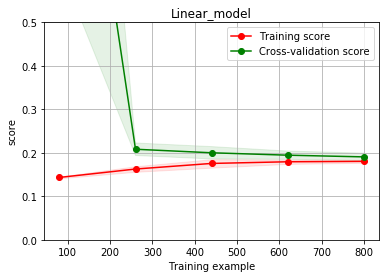

In [32]:
plot_learning_curve(LinearRegression(), 'Linear_model', train_X[:1000], train_y_ln[:1000], ylim=(0.0, 0.5), cv=5, n_jobs=1)

In [33]:
# 多种模型对比
train = sample_feature[continuous_feature_names + ['price']].dropna()

train_X = train[continuous_feature_names]
train_y = train['price']
train_y_ln = np.log(train_y + 1)

In [34]:
# 线性模型&嵌入式特征选择
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

models = [LinearRegression(), Ridge(), Lasso()]

result = dict()

for model in models:
    model_name = str(model).split('(')[0]
    scores = cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv=5, scoring=make_scorer(mean_absolute_error))
    result[model_name] = scores
    print(model_name + ' is finished')

LinearRegression is finished
Ridge is finished
Lasso is finished


In [35]:
# 对三种方法的效果对比
result = pd.DataFrame(result)
result.index = ['cv' + str(x) for x in range(1,6)]
result

,LinearRegression,Ridge,Lasso
cv1,0.190792,0.194832,0.383899
cv2,0.193758,0.197632,0.381893
cv3,0.194132,0.198123,0.384090
cv4,0.191825,0.195670,0.380526
cv5,0.195758,0.199676,0.383611


intercept:18.75074946558032


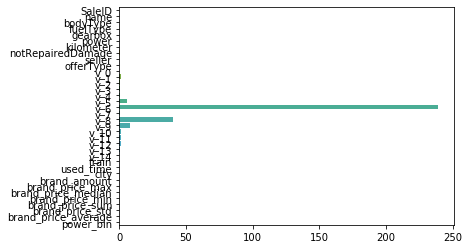

In [36]:
model = LinearRegression().fit(train_X, train_y_ln)
print('intercept:' + str(model.intercept_))
sns.barplot(abs(model.coef_), continuous_feature_names)

intercept:4.6717097872126025


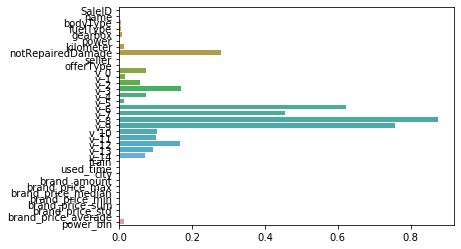

In [37]:
model = Ridge().fit(train_X, train_y_ln)
print('intercept:' + str(model.intercept_))
sns.barplot(abs(model.coef_), continuous_feature_names)

intercept:8.672182462666198


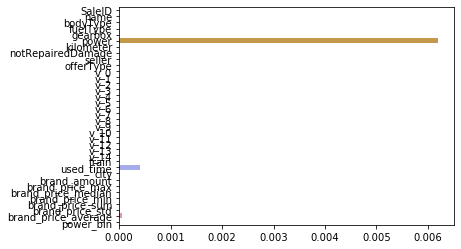

In [38]:
model = Lasso().fit(train_X, train_y_ln)
print('intercept:' + str(model.intercept_))
sns.barplot(abs(model.coef_), continuous_feature_names)

In [39]:
# 非线性模型
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from xgboost.sklearn import XGBRegressor
from lightgbm.sklearn import LGBMRegressor

In [40]:
models = [LinearRegression(), DecisionTreeRegressor(), RandomForestRegressor(), GradientBoostingRegressor(), MLPRegressor(solver='lbfgs', max_iter=100), XGBRegressor(n_estimators=100, objective='reg:squarederror'), LGBMRegressor(n_estimators=100)]

In [42]:
result = dict()
for model in models:
    model_name = str(model).split('(')[0]
    scores = cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv=5, scoring=make_scorer(mean_absolute_error))
    result[model_name] = scores
    print(model_name + ' is finished')

LinearRegression is finished
DecisionTreeRegressor is finished
RandomForestRegressor is finished
GradientBoostingRegressor is finished
MLPRegressor is finished
XGBRegressor is finished
LGBMRegressor is finished


In [43]:
result = pd.DataFrame(result)
result.index = ['cv' + str(x) for x in range(1,6)]
result

,LinearRegression,DecisionTreeRegressor,RandomForestRegressor,GradientBoostingRegressor,MLPRegressor,XGBRegressor,LGBMRegressor
cv1,0.190792,0.197010,0.132606,0.168900,313.433844,0.142378,0.141544
cv2,0.193758,0.192419,0.134256,0.171831,395.980896,0.140922,0.145501
cv3,0.194132,0.189087,0.133699,0.170935,306.731345,0.139393,0.143887
cv4,0.191825,0.189840,0.132587,0.169083,615.860613,0.137492,0.142497
cv5,0.195758,0.203357,0.137341,0.174094,492.788691,0.143733,0.144852


In [45]:
## LGB的参数集合：

objective = ['regression', 'regression_l1', 'mape', 'huber', 'fair']

num_leaves = [3,5,10,15,20,40, 55]
max_depth = [3,5,10,15,20,40, 55]
bagging_fraction = []
feature_fraction = []
drop_rate = []

In [46]:
# 模型调参
# 1 贪心调参
best_obj = dict()
for obj in objective:
    model = LGBMRegressor(objective=obj)
    score = np.mean(cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)))
    best_obj[obj] = score
    
best_leaves = dict()
for leaves in num_leaves:
    model = LGBMRegressor(objective=min(best_obj.items(), key=lambda x:x[1])[0], num_leaves=leaves)
    score = np.mean(cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)))
    best_leaves[leaves] = score
    
best_depth = dict()
for depth in max_depth:
    model = LGBMRegressor(objective=min(best_obj.items(), key=lambda x:x[1])[0],
                          num_leaves=min(best_leaves.items(), key=lambda x:x[1])[0],
                          max_depth=depth)
    score = np.mean(cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)))
    best_depth[depth] = score

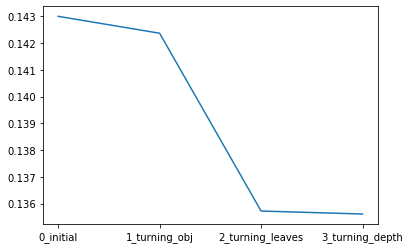

In [47]:
sns.lineplot(x=['0_initial','1_turning_obj','2_turning_leaves','3_turning_depth'], y=[0.143 ,min(best_obj.values()), min(best_leaves.values()), min(best_depth.values())])

In [48]:
# 2 Grid Search 调参
from sklearn.model_selection import GridSearchCV

parameters = {'objective': objective , 'num_leaves': num_leaves, 'max_depth': max_depth}
model = LGBMRegressor()
clf = GridSearchCV(model, parameters, cv=5)
clf = clf.fit(train_X, train_y)

clf.best_params_

{'max_depth': 15, 'num_leaves': 55, 'objective': 'regression'}

In [49]:
model = LGBMRegressor(objective='regression', num_leaves=55, max_depth=15)

In [50]:
np.mean(cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)))

0.13754833106731224

In [52]:
# 3 贝叶斯调参
from bayes_opt import BayesianOptimization
def rf_cv(num_leaves, max_depth, subsample, min_child_samples):
    val = cross_val_score(
        LGBMRegressor(objective = 'regression_l1',
            num_leaves=int(num_leaves),
            max_depth=int(max_depth),
            subsample = subsample,
            min_child_samples = int(min_child_samples)
        ),
        X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)
    ).mean()
    return 1 - val

In [53]:
rf_bo = BayesianOptimization(
    rf_cv,
    {
    'num_leaves': (2, 100),
    'max_depth': (2, 100),
    'subsample': (0.1, 1),
    'min_child_samples' : (2, 100)
    }
)

In [54]:
rf_bo.maximize()

|   iter    |  target   | max_depth | min_ch... | num_le... | subsample |
-------------------------------------------------------------------------
|  1        |  0.8344   |  24.34    |  74.73    |  8.491    |  0.3154   |
|  2        |  0.8611   |  89.8     |  69.78    |  40.74    |  0.1787   |
|  3        |  0.8575   |  27.09    |  68.54    |  31.62    |  0.8848   |
|  4        |  0.8576   |  90.63    |  77.76    |  31.26    |  0.7619   |
|  5        |  0.8671   |  82.08    |  22.69    |  74.48    |  0.2662   |
|  6        |  0.8671   |  85.13    |  20.08    |  75.15    |  0.4367   |
|  7        |  0.8252   |  3.163    |  96.66    |  98.41    |  0.5254   |
|  8        |  0.8119   |  97.99    |  4.623    |  4.422    |  0.4356   |
|  9        |  0.8406   |  4.365    |  3.205    |  94.66    |  0.7153   |
|  10       |  0.869    |  99.44    |  99.87    |  95.25    |  0.6397   |
|  11       |  0.8642   |  63.93    |  99.93    |  54.82    |  0.7661   |
|  12       |  0.8692   |  68.1     | 

In [55]:
1 - rf_bo.max['target']

0.13052894587373443

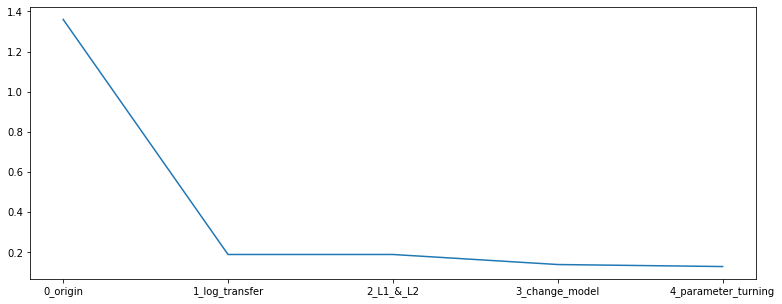

In [56]:
plt.figure(figsize=(13,5))
sns.lineplot(x=['0_origin', '1_log_transfer', '2_L1_&_L2', '3_change_model', '4_parameter_turning'], y=[1.36, 0.19, 0.19, 0.14, 0.13] )